In [1]:
import numpy as np
import torch
import sys
sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from sobolev import Sobolev
from sobolev import Sobolev
from solver import Solver
from utils import matmul
import surrogates
import time
sys.path.insert(1, '/home/suarez08/minterpy/src')
from diffeomorphisms import hyper_rect
import matplotlib
import matplotlib.pyplot as plt
#style.use('dark_background')
matplotlib.rcdefaults() 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

Parameters required for interpolation

In [3]:
%%time
start = time.time()
deg_quad = 50
rect = rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])
diffeo_param = hyper_rect(*rect)
sob_param = Sobolev(deg=deg_quad, dim=2)
##### Sobolev norm for the inteprolation
sob_param.set_s(0)
#####
x_plt, _, _, x, _, _ = sob_param.get_quad()
metric_param = sob_param.metric()
W_param = sob_param.get_leja_weights()
u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
metric_2d = sob_param.metric(weak=True)
x_l = sob_param.get_xs()
x = x_l[0][0]#np.linspace(-1,1,10)
#Create Regression Matrix
X_p = u_ob.data_axes([x,x]).T
X_plg = u_ob.data_axes([x,x]).T
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 1.60s
CPU times: user 4.9 s, sys: 817 ms, total: 5.72 s
Wall time: 1.6 s


In [4]:
X_p.shape

torch.Size([2601, 2601])

## Sample grid 

In [6]:
x_us = np.linspace(-1,1,101)
x = x_us[np.random.choice(len(x_us), 101, replace=False)]
X_p = u_ob.data_axes([x,x]).T
X_p.shape

torch.Size([10201, 2601])

Function to be interpolated

gt -> Ground truth as a function

Fr -> Evaluation of gt at the grid x

In [7]:
wx= 1
wy= 1
x = torch.tensor(x)
X, Y = torch.meshgrid(x,x)
### Ground Truth Vector
omega= 1
A= 0.1
Fr = ((A*omega**2*torch.sin(omega*X) + 
         50*(1/torch.cosh(5*X)**2)*torch.tanh(5*X))*torch.tanh(Y)).reshape(-1)
#Fr = (1+0*X).reshape(-1)
#(torch.cos(X)*torch.sin(Y)).reshape(-1)
#np.cos(x)*np.sin(y)#
def gt_x(x,y):
    return (A*omega**2*np.sin(omega*x) + 
         50*(1/np.cosh(5*x)**2)*np.tanh(5*x))*np.tanh(y)

/trinity/shared/pkg/devel/python/3.10.4/venv/venv_a/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


start = time.time()
K = torch.eye(len(X_p))
KsK = matmul(X_p.T, X_p)#+0.00001*torch.eye(len(X_p.T))
Ksf = matmul(X_p.T, Fr)
w = matmul(KsK.inverse(), Ksf)
#print(w.shape)
#w = torch.tensor(sp.linalg.lstsq(KsK.detach().numpy(), Ksf.detach().numpy())[0])
#w =  torch.tensor(sp.linalg.lstsq(X_p.detach().numpy(), Fr)[0])
u_ob.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

In [8]:
import scipy
reg_coeff,_,_,_ = scipy.linalg.lstsq(X_p,Fr)
u_ob.set_weights(torch.tensor(reg_coeff))

u_ob.set_weights_val(0.1)
theta_0 =  list(u_ob.parameters())[0][0]
dt = 2
inv_op = (torch.eye(len(KsK))+dt*KsK).inverse()
w = theta_0
for k in range(20000):
    w = matmul(inv_op, w +dt*Ksf)
u_ob.set_weights(w)

In [9]:
b = np.linspace(-1,1,200)#np.array([x[0]])#np.linspace(-1,1,100)
xf= np.linspace(-1,1,200)#x#np.linspace(-1,1,100)
BF, XF = np.meshgrid(b,xf)
X_test = u_ob.data_axes([b,xf]).T
X_final = u_ob.data_axes([x,x]).T
pred = u_ob(X_test).T[0].reshape(len(b),len(xf)).detach().numpy()
X, Y = torch.meshgrid(torch.tensor(xf),torch.tensor(b))
Fr = (torch.sin(wx*X)*torch.cos(wy*Y)).reshape(-1)
GT = Fr.reshape(len(xf),len(b))

SPH Quadrature in 1D

In [10]:
%%time
start = time.time()
deg_quad = 50
rect = rect = np.array([[-1.0, 1.0]])
diffeo_param = hyper_rect(*rect)
sob_param = Sobolev(deg=deg_quad, dim=1)
##### Sobolev norm for the inteprolation
sob_param.set_s(0)
#####
x_plt, _, _, x, _, _ = sob_param.get_quad()
metric_param = sob_param.metric()
W_param = sob_param.get_leja_weights()
u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
metric_2d = sob_param.metric(weak=True)
x_l = sob_param.get_xs()
x = x_l[0][0]#np.linspace(-1,1,10)
#Create Regression Matrix
X_p = u_ob.data_axes([x]).T
X_plg = u_ob.data_axes([x]).T
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 0.04s
CPU times: user 69.9 ms, sys: 5.48 ms, total: 75.4 ms
Wall time: 37.1 ms


In [11]:
x_us = np.linspace(-1,1,101)
x = x_us[np.random.choice(len(x_us), 101, replace=False)]
X_p = u_ob.data_axes([x]).T
X_p.shape
dx = abs(x_us[0]-x_us[1])
epsilon = 1/2*dx

In [12]:
def w_i(a,e):
    return (3*a)/2 + (2*a**3)/e**2 - (7*a**2)/(2*e) + (37*e)/48 - (3*e**2)/2 + (7*e**3)/6 - (5*e**4)/16
    

In [10]:
def kernel(z, eps):
    alphad = 2.0/eps
    z = np.abs(z)
    if z < 0.5*eps:
        return alphad*(2.0/3.0 - (2.0*z/eps)**2 + 0.5*(2.0*z/eps)**3)
    elif z >= 0.5*eps and z < eps:
        return alphad*(((1.0/6.0)*(2.0-2.0*z/eps)**3))
    else:
        return 0.0 

In [13]:
W_i= [2/epsilon*w_i(x[i],epsilon) for i in range(len(x))]
W = torch.tensor(np.diag(W_i), dtype= torch.float64)
X_reg = torch.matmul(W,X_p)
#X_reg = X_p

In [14]:
A= 0.1
X = torch.tensor(x)
Fr = ((A*omega**2*torch.sin(omega*X) + 
         50*(1/torch.cosh(5*X)**2)*torch.tanh(5*X))).reshape(-1)
#Fr = (1+0*X).reshape(-1)
#(torch.cos(X)*torch.sin(Y)).reshape(-1)
#np.cos(x)*np.sin(y)#
def gt_x(x):
    return (A*omega**2*np.sin(omega*x) + 
         50*(1/np.cosh(5*x)**2)*np.tanh(5*x))

In [15]:
import scipy
reg_coeff,_,_,_ = scipy.linalg.lstsq(X_reg,Fr)
u_ob.set_weights(torch.tensor(reg_coeff))

In [16]:
np.mean(abs(pred-gt_x(xf))), np.max(abs(pred-gt_x(xf)))

(6.624611483258818, 21.865142993385476)

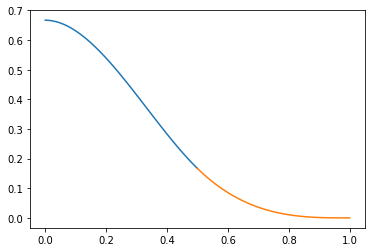

In [17]:
xl = np.linspace(0,1/2,100)
xr = np.linspace(1/2,1,100)
plt.plot(xl,2/3-4*xl**2+1/2*(2*xl)**3)
plt.plot(xr,1/6*(2-2*xr)**3)

In [325]:
def Erf(x):
    return scipy.special.erf(x)
def M(a,b,e):
    return np.exp(-(a-b)**2/(8*e**2))*(Erf((2+a+b)/(2*np.sqrt(2)*e))-Erf((-2+a+b)/(2*np.sqrt(2)*e)))/(4*e*np.sqrt(2*np.pi))

In [19]:
import scipy
x = np.linspace(-1,1,200)
def g(x):
    return x**2

In [20]:
X,Y = np.meshgrid(x,x)
X = X.flatten()
Y = Y.flatten()

In [21]:
def MSE(x):
    dx = abs(x[0]-x[1])
    return abs(np.sum(g(x)**2*dx)-2/21)

In [22]:
x = [np.linspace(-1.1,1.1,100), np.linspace(-1.1,1.1,500), np.linspace(-1.1,1.1,1000),
    np.linspace(-1.1,1.1,1500), np.linspace(-1.1,1.1,2000), np.linspace(-1.1,1.1,2500),
    np.linspace(-1.1,1.1,3000), np.linspace(-1.1,1.1,3500)]
#M_e = [MSE(x[k]) for k in range(len(x))]

In [23]:
x_M = [np.linspace(-1.0,1.0,100), np.linspace(-1.0,1.0,500), np.linspace(-1.0,1.0,1000),
    np.linspace(-1.0,1.0,1500), np.linspace(-1.0,1.0,2000), np.linspace(-1.0,1.0,2500),
    np.linspace(-1.0,1.0,3000), np.linspace(-1.0,1.0,3500)]
M_e = [MSE(x_M[k]) for k in range(len(x_M))]

In [24]:
def sph_quad(x):
    X,Y = np.meshgrid(x,x)
    X = X.flatten()
    Y = Y.flatten()
    dx = abs(x[0]-x[1])
    e= 2*dx
    return abs(np.sum(g(X)*g(Y)*M(X,Y,e)*dx**2)-2/21)

In [ ]:
M_sph = [sph_quad(x[k]) for k in range(len(x))]

In [26]:
delta_x = np.array([abs(x[k][0]-x[k][1]) for k in range(len(x))])

Text(0, 0.5, ' Quadrature Error')

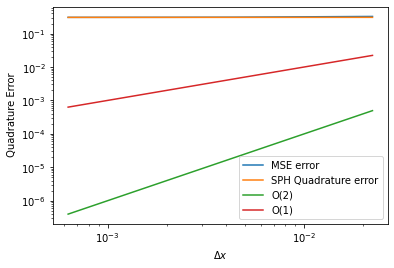

In [27]:
plt.loglog(delta_x, np.array(M_e), label='MSE error')
plt.loglog(delta_x, np.array(M_sph), label='SPH Quadrature error')
plt.loglog(delta_x,delta_x**2, label ='O(2)')
plt.loglog(delta_x,delta_x, label ='O(1)')
plt.legend()
plt.xlabel('$\Delta x$')
plt.ylabel(' Quadrature Error')

In [313]:
def N (a,e,dx):
    return (1/(4*e*np.sqrt(np.pi)))*(Erf((1-a)/e)+Erf((1+a)/e))*dx**2

In [451]:
def k_2order(x,a,e):
    return (1/(e*np.sqrt(2*np.pi))*np.exp(-1/2*((x-a)/e)**2))**2

In [520]:
def gt(x):
    return x**3*np.tanh(10*(x-np.pi))+np.cos(15*x)

In [521]:
x = np.linspace(-1,1,100)
dx = abs(x[0]-x[1])
X_p = u_ob.data_axes([x]).T
deg_quad = 10
u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
e = 2*dx
N_m = np.diag(N(x,e,dx))

In [522]:
def sph_reg(n_points, deg_quad):
    u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
    x_p = np.linspace(-1,1,n_points)
    idx = np.random.randint(1,2*n_points,n_points)
    x = x_p#x_p[idx]
    dx = abs(x[0]-x[1])
    X_p = u_ob.data_axes([x]).T
    e = 4*dx
    #N_m = np.diag(N(x,e,dx))
    N_m = np.diag(np.array([quad(k_2order,-1,1,args=(a,e))[0] for a in x]))*dx**2
    #Compute 
    K = np.matmul(np.matmul(X_p.T,N_m),X_p)
    f = np.matmul(np.matmul(X_p.T,N_m),gt(x))
    #reg_coeff,_,_,_ = scipy.linalg.lstsq(K,f)
    reg_coeff = torch.matmul(K.inverse(),f)
    u_ob.set_weights(torch.tensor(reg_coeff))
    return u_ob

In [523]:
u_ob = sph_reg(1000,50)

/tmp/ipykernel_69674/3092245164.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_ob.set_weights(torch.tensor(reg_coeff))


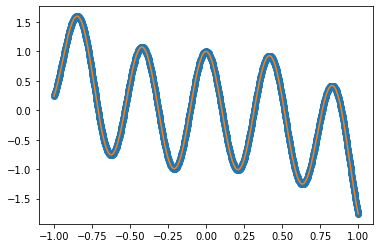

In [524]:
x_t = np.linspace(-1,1,1000)
X_tr = u_ob.data_axes([x_t]).T
G = u_ob(X_tr).T[0].detach().numpy()
plt.plot(x_t,G, 'o')
plt.plot(x_t, gt(x_t))

In [525]:
np.mean(abs(G-x_t**2)),np.max(abs(G-x_t**2))

(0.7332083149840686, 2.759687912858791)

In [526]:
def MSE_reg(n_points, deg_quad):
    u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
    x_p = np.linspace(-1,1,n_points)
    idx = np.random.randint(1,2*n_points,n_points)
    x = x_p#x_p[idx]
    X_p = u_ob.data_axes([x]).T
    #Compute 
    K = np.matmul(X_p.T,X_p)
    f = np.matmul(X_p.T,gt(x))
    #reg_coeff,_,_,_ = scipy.linalg.lstsq(K,f)
    reg_coeff = torch.matmul(K.inverse(),f)
    u_ob.set_weights(torch.tensor(reg_coeff))
    return u_ob

In [527]:
u_ob = MSE_reg(100,100)

/tmp/ipykernel_69674/3205795487.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_ob.set_weights(torch.tensor(reg_coeff))


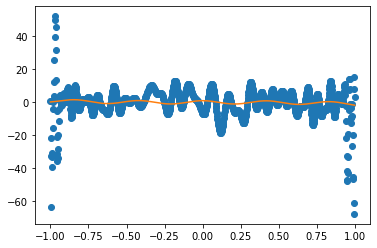

In [528]:
x_t = np.linspace(-1,1,1000)
X_tr = u_ob.data_axes([x_t]).T
G = u_ob(X_tr).T[0].detach().numpy()
plt.plot(x_t,G, 'o')
plt.plot(x_t, gt(x_t))

In [529]:
np.mean(abs(G-x_t**2)),np.max(abs(G-x_t**2))

(6.090957844569115, 68.72549493871159)

In [530]:
x_t = np.linspace(-1,1,1000)
X_tr = u_ob.data_axes([x_t]).T

In [531]:
N_d =np.linspace(2,196*2,196)

ValueError: x and y must have same first dimension, but have shapes (196,) and (170,)

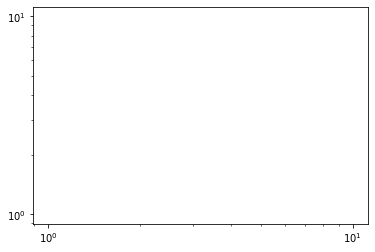

In [532]:
plt.loglog(N_d,e_mse, label ='MSE_loss');
plt.loglog(N_d,e_sph, label ='SPH_loss');
plt.loglog(N_d, (1/N_d)**2)
plt.legend()

In [ ]:
def sph_reg_2(n_points, deg_quad):
    u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
    x_p = np.linspace(-1,1,2*n_points)
    idx = np.random.randint(1,2*n_points,n_points)
    x = x_p[idx]
    dx = abs(x[0]-x[1])
    X_p = u_ob.data_axes([x]).T
    e = 4*dx
    #N_m = np.diag(N(x,e,dx))
    M_sph = np.array([[M(x[i],x[j],e) for i in range(len(x))]for j in range(len(x))])*dx**2
    #Compute 
    K = np.matmul(np.matmul(X_p.T,M_sph),X_p)
    f = np.matmul(np.matmul(X_p.T,M_sph),gt(x))
    #reg_coeff,_,_,_ = scipy.linalg.lstsq(K,f)
    reg_coeff = torch.matmul(K.inverse(),f)
    u_ob.set_weights(torch.tensor(reg_coeff))
    return u_ob

In [533]:
x_t = np.linspace(-1,1,1000)
X_tr = u_ob.data_axes([x_t]).T
e_sph_2 = [  np.mean(abs(sph_reg_2(2*k, 100)(X_tr).T[0].detach().numpy()-gt(x_t))) for k in range(4,200)]

/tmp/ipykernel_69674/2544834466.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_ob.set_weights(torch.tensor(reg_coeff))
/tmp/ipykernel_69674/643674817.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-(a-b)**2/(8*e**2))*(Erf((2+a+b)/(2*np.sqrt(2)*e))-Erf((-2+a+b)/(2*np.sqrt(2)*e)))/(4*e*np.sqrt(2*np.pi))
/tmp/ipykernel_69674/643674817.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-(a-b)**2/(8*e**2))*(Erf((2+a+b)/(2*np.sqrt(2)*e))-Erf((-2+a+b)/(2*np.sqrt(2)*e)))/(4*e*np.sqrt(2*np.pi))


KeyboardInterrupt: 

In [ ]:
plt.loglog(N_d,e_mse, label ='MSE_loss');
plt.loglog(N_d,e_sph, label ='SPH_loss');
plt.loglog(N_d, e_sph_2, label ='SPH_loss_2');
plt.loglog(N_d, (1/N_d)**5)
plt.legend()

In [302]:
def K_3(x,a ,e): 
    return 2/3 - 9/8*((2*(x-a+1))/e)**2 + 19/24*((2*(x-a+1))/e)**3 - 5/32*((2*(x-a+1))/e)**4

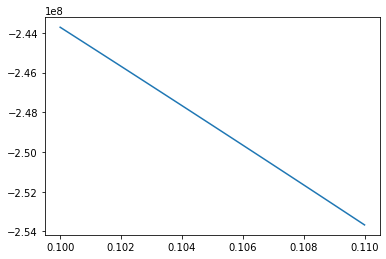

In [303]:
a = 0.1
e = 0.01
plt.plot(np.linspace(a,a+e,100),K_3(np.linspace(a,a+e,100),a,e))

In [304]:
def K_1(x,a ,e): 
    if a<x<=a+e:
        return (2/3-9/2*((x-a)/e)**2+19/3*((x-a)/e)**3-5/2*((x-a)/e)**4)
    elif a-e<x<=a:
        return (2/3-9/2*((x-a)/e)**2-19/3*((x-a)/e)**3-5/2*((x-a)/e)**4)
    else: 
        return 0
def K_2(x,a ,e): 
    if a<x<=a+e:
        return (2/3-9/2*((x-a)/e)**2+19/3*((x-a)/e)**3-5/2*((x-a)/e)**4)**2
    elif a-e<x<=a:
        return (2/3-9/2*((x-a)/e)**2-19/3*((x-a)/e)**3-5/2*((x-a)/e)**4)**2
    else: 
        return 0
def K_p(x,a,b,e):
    return K_1(x,a,e)*K_1(x,b,e)

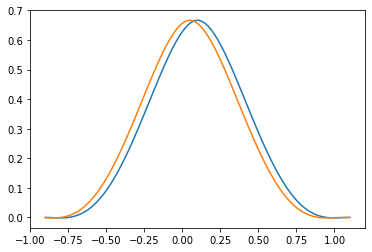

In [305]:
a = 0.1
b = 0.05
e = 1
f = [K_1(x,a,e) for x in np.linspace(a-e,a+e,100)]
f2 = [K_1(x,b,e) for x in np.linspace(a-e,a+e,100)]
plt.plot(np.linspace(a-e,a+e,100),f)
plt.plot(np.linspace(a-e,a+e,100),f2)

In [306]:
from scipy.integrate import quad
a= 0.3
b = 0.25
e = 1
N=np.array([quad(K_1,-1,1,args=(a,e))[0] for a in np.linspace(-1,1,10)])
N

array([0.25      , 0.38527748, 0.46771749, 0.49691358, 0.50009738,
       0.50009738, 0.49691358, 0.46771749, 0.38527748, 0.25      ])

In [307]:
x = np.linspace(-1,1,10)
M=np.array([[quad(K_p,-1,1,args=(a,b,e))[0] for a in x]for b in x])

In [465]:
n_points =10
x = np.linspace(-1,1,2*n_points)
idx = np.random.randint(1,2*n_points,n_points)
x[idx]

array([-0.36842105,  0.26315789, -0.36842105,  0.05263158,  0.47368421,
        1.        ,  0.68421053,  0.47368421,  0.57894737, -0.15789474])

In [491]:
def sph_reg_3(n_points, deg_quad):
    u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
    x_p = np.linspace(-1,1,n_points)
    #idx = np.random.randint(1,2*n_points,n_points)
    x = x_p#x_p[idx]
    dx = abs(x[0]-x[1])
    X_p = u_ob.data_axes([x]).T
    e = 4*dx
    #N_m = np.diag(N(x,e,dx))
    M_sph = np.array([[quad(K_p,-1,1,args=(a,b,e))[0] for a in x]for b in x])*dx**2
    #Compute 
    K = np.matmul(np.matmul(X_p.T,M_sph),X_p)
    f = np.matmul(np.matmul(X_p.T,M_sph),gt(x))
    reg_coeff,_,_,_ = scipy.linalg.lstsq(K,f)
    #reg_coeff = torch.matmul(K.inverse(),f)
    u_ob.set_weights(torch.tensor(reg_coeff))
    return u_ob

In [498]:
def sph_reg_4(n_points, deg_quad):
    u_ob = surrogates.Polynomial(n=deg_quad,p=np.inf, dim=1)
    x_p = np.linspace(-1,1,n_points)
    idx = np.random.randint(1,n_points,n_points)
    x = x_p#x_p[idx]
    dx = abs(x[0]-x[1])
    X_p = u_ob.data_axes([x]).T
    e = 4*dx
    #N_m = np.diag(N(x,e,dx))
    M_sph = np.diag(np.array([quad(K_2,-1,1,args=(a,e))[0] for a in x]))*dx**2
    #Compute 
    K = np.matmul(np.matmul(X_p.T,M_sph),X_p)
    f = np.matmul(np.matmul(X_p.T,M_sph),gt(x))
    reg_coeff,_,_,_ = scipy.linalg.lstsq(K,f)
    #reg_coeff = torch.matmul(K.inverse(),f)
    u_ob.set_weights(torch.tensor(reg_coeff))
    return u_ob

In [534]:
x_t = np.linspace(-0.9,0.9,1000)
deg_model = 50
X_tr = MSE_reg(4, deg_model).data_axes([x_t]).T
e_mse = [ np.mean(abs(MSE_reg(2*k, 50)(X_tr).T[0].detach().numpy()-gt(x_t))) for k in range(deg_model-20,200)]

/tmp/ipykernel_69674/3205795487.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_ob.set_weights(torch.tensor(reg_coeff))


In [535]:
e_sph = [ np.mean(abs(sph_reg(2*k, deg_model)(X_tr).T[0].detach().numpy()-gt(x_t))) for k in range(deg_model-20,200)]

/tmp/ipykernel_69674/3092245164.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_ob.set_weights(torch.tensor(reg_coeff))


In [536]:
e_sph_3 = [  np.mean(abs(sph_reg_4(2*k, deg_model)(X_tr).T[0].detach().numpy()-gt(x_t))) for k in range(deg_model-20,200)]

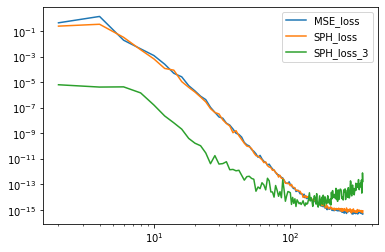

In [537]:
N_d =np.linspace(2,len(e_mse)*2,(len(e_mse)))
plt.loglog(N_d,e_mse, label ='MSE_loss');
plt.loglog(N_d,e_sph, label ='SPH_loss');
plt.loglog(N_d, e_sph_3, label ='SPH_loss_3');
#plt.loglog(N_d[0:len(np.array(e_sph_4))], e_sph_4, label ='SPH_loss_4');
#plt.loglog(N_d, (1/N_d)**5, label ='O(50)')
plt.legend()

Cheb SPH approx

In [11]:
def Dphi(x):
    return 1/2*np.pi*np.sin((np.pi*(-1 + n + n*x))/(2*n))
    #return np.pi*np.cos(np.pi*x)
def Phi_inv(x,n):
    return 2/n*(1/2*(np.arccos(-x)*2*n/np.pi +1)-n/2)
def Dphi_inv(x,n):
    return 2/(np.pi*np.sqrt(1 - x**2))

In [106]:
def f(x):
    return 1/(1000*x**1+1)#np.sin(10*x)**2+np.cos(4*x)+x*np.tan(3*x)
n = 500
x_t = np.linspace(-1,1,n)
h = abs(x_t[0]-x_t[1])
eps = 2*h
def Phi(x,n):
    return -np.cos((2*(x*n/2+n/2)-1)/(2*n)*np.pi)
phi_xt = np.linspace(-1,1,n)
h = abs(phi_xt[0]-phi_xt[1])

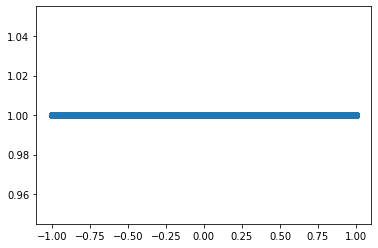

In [107]:
plt.scatter(Phi(phi_xt,n), np.zeros(len(phi_xt))+1)

In [108]:
x_test = np.linspace(-0.9,0.9,34)
h= abs((x_t[0]-x_t[1]))
F_sph = np.array([np.sum([f((x_t[i]+x_t[i-1])/2)*kernel((x_t[i]+x_t[i-1])/2-x_test[j],eps)*h for i in range(len(x_t))]) 
                  for j in range(len(x_test))])
F_sph_cheb = np.array([np.sum([f((x_t[i]+x_t[i-1])/2)*kernel((x_t[i]+x_t[i-1])/2-x_test[j],eps)*abs(Phi(x_t[i],n)-Phi(x_t[i-1],n))*
                               Dphi_inv(Phi((x_t[i]+x_t[i-1])/2,n),n) for i in range(len(x_t))]) 
                  for j in range(len(x_test))])
np.mean(abs(F_sph-f(x_test))), np.mean(abs(F_sph_cheb-f(x_test)))

(1.6766661301330053e-05, 1.6758085036445975e-05)

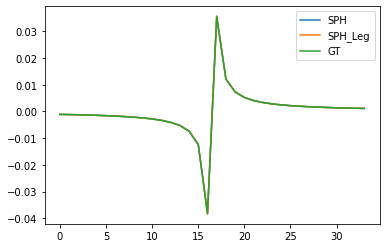

In [109]:
plt.plot(F_sph, label ='SPH');
plt.plot(F_sph_cheb, label ='SPH_Leg');
plt.plot(f(x_test), label = 'GT')
plt.legend()